# PhastPhase example
In this example, we use PhastPhase to retireve phase and amplitude of a complex object, determined by chosen images.

In [1]:
# (reload source code automatically and plots inline)
%load_ext autoreload
%autoreload 2
%matplotlib inline

from matplotlib import pyplot as plt

import cv2 as cv
import numpy as np
import sys, os

sys.path.append(os.path.join(os.getcwd(), '../../phastphase'))

import phastphase

### Helper functions
Start by making some helper functions for reading image files, normalizing them and making them the wanted size.

In [2]:
import scipy.ndimage
from PIL import Image

def process_image(filename,wanted_size):
    original = Image.open(filename)
    beaver = np.array(original.convert('L'))
    beaver = beaver / np.amax(beaver)

    ########## zoom ################
    # Make this have "actual_num" pixels
    #wanted_size = [200,200]
    nx,ny = np.shape(beaver)
    factor = (np.array(wanted_size) / np.array([nx,ny]))
    array_downsampled = scipy.ndimage.zoom(beaver, factor, order=0)
    
    return array_downsampled

def plot_mag_phase(complex_image, bright_spot = []):
    image = complex_image.copy()
    if len(bright_spot)>0:
        image[bright_spot] = 0
    _, ax = plt.subplots(1,2)
    im0 = ax[0].imshow(np.abs(image), cmap="Blues")
    plt.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)
    im1 = ax[1].imshow(np.angle(image),cmap="twilight", interpolation="none")
    ax[1].set_yticks([])
    plt.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)
    plt.show()

### Create the phase and Amplitude profile
Choose images to be the phase and amplitude profile. Notice that if the amplitude background is set to 0, the phase is ill defined there, so we set the 0 amplitude to some weak value.

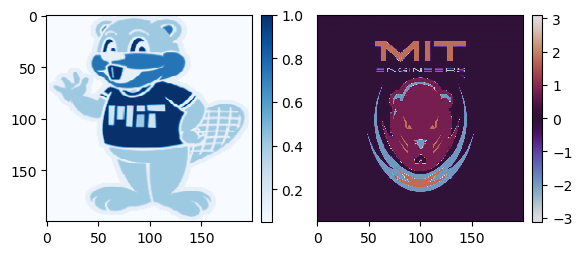

In [3]:
#Amplitude profile
filename = 'beaver.png'
wanted_size = [200,200]
Amplitude = process_image(filename,wanted_size)
Amplitude[Amplitude==0] = 0.05

#Phase profile
filename = 'mit-engineers7834.jpg'
wanted_size = [200,200]
Phase = process_image(filename,wanted_size)* 1.99 * np.pi

complex_image = Amplitude * np.exp(1j * Phase)

plot_mag_phase(complex_image)

### Make Schwartz
phastphase only (verifiably) works on Schwarz objects, which are objects with power concentrated in a bright spot in the nearfield. We make sure our object is Schwartz by adding a "bright spot". 

In [5]:
#Choose how bright the bright spot should be, with respect to N the number of pixels
N = np.shape(complex_image)[0]*np.shape(complex_image)[1]

def make_Schwartz(complex_image, val =  np.sqrt(N)):

    near_field = complex_image.copy()

    #normalize by the 1-norm
    norm = np.linalg.norm(near_field, ord = 1)
    near_field = near_field / norm

    print('Proportion of bright spot to 1-norm of rest of object: %.2f'%(val/norm))
    print('Proportion of bright spot to next brightest point of rest of object: %.2f'%(val/np.amax(np.abs(near_field))))

    #Put the bright spot in the near field
    near_field[0:1,0:1]= val
    return near_field

near_field = make_Schwartz(complex_image, val =  np.sqrt(N))

Proportion of bright spot to 1-norm of rest of object: 1.69
Proportion of bright spot to next brightest point of rest of object: 23728.24


### Fourier Transform
Take the Fourier transform for the far field, and oversample it by at least 2 (critical). We normalize for making sure energy is conserved.

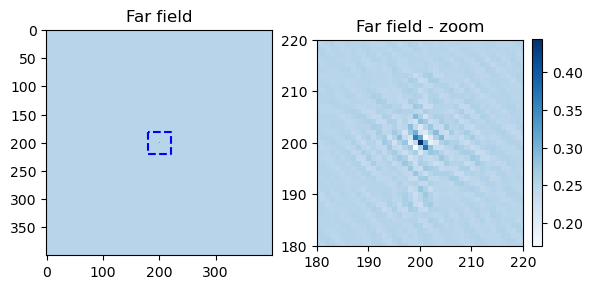

In [6]:
def do_Fourier(near_field, oversampling = 2):

    far_field = np.abs(np.fft.fft2(near_field, s=np.array(np.shape(near_field))*oversampling))**2 
    #Normalize (energy conservation)
    far_field = far_field / (np.shape(far_field)[0]*np.shape(far_field)[1])

    #make sure there are no negative elements in the far field
    far_field[far_field < 0] = 0

    fig,ax = plt.subplots(1,2)
    ax0 = ax[0].imshow(np.fft.fftshift(far_field), cmap = 'Blues')
    s = 20
    x0 = np.shape(far_field)[1]/2 - 20
    x1 = np.shape(far_field)[1]/2 + 20
    y0 = np.shape(far_field)[0]/2 - 20
    y1 = np.shape(far_field)[0]/2 + 20
    ax[0].plot([x0,x0,x1,x1,x0],[y0,y1,y1,y0,y0],'--b')
    ax1 = ax[1].imshow((np.fft.fftshift(far_field)), cmap = 'Blues')
    ax[1].set_xlim([x0,x1])
    ax[1].set_ylim([y0,y1])
    plt.colorbar(ax1, ax=ax[1], fraction=0.046, pad=0.04)
    ax[0].set_title('Far field')
    ax[1].set_title('Far field - zoom')
    
    return far_field

far_field = do_Fourier(near_field, oversampling = 2)

### Reconstruct using phastphase
and calcualte the relative squared error:
$$err = \frac{\|A_{phastphase} - A_{groundtruth}\|_2}{\|A_{groundtruth}\|_2}$$
Where $ A_{groundtruth}$ is the complex ground truth object, $A_{phastphase}$ is the reconstruced complex object, and $\|x\|_2$ is the L2 norm.

Adam:   0%|                                                                                     | 0/10 [00:00<?, ?it/s]C:\Users\sivan\OneDrive\Documents\phase retrieval\slmsuite-examples\examples\../../phastphase\phastphase\__init__.py:242: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten\src\ATen/core/TensorBody.h:494.)
  iterator.set_description(f"Adam (loss={loss}, grad={loss.grad})")
Adam (loss=0.5925814576958062, grad=None): 100%|███████████████████████████████████████| 10/10 [00:02<00:00,  4.48it/s]


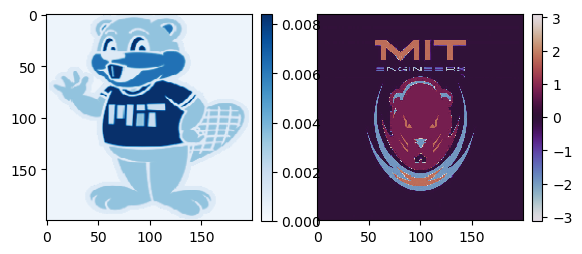

Reconstruction Relative Squared Error is 2.00e-12


In [7]:
reconstruction = phastphase.retrieve(
    far_field,
    wanted_size,             #known support
    reference_point=[0,0],    #known reference bright spot
    verbose = True
)

plot_mag_phase(reconstruction,bright_spot = [0,0])

#error
err = np.linalg.norm(reconstruction - near_field) / np.linalg.norm(near_field)
print(f'Reconstruction Relative Squared Error is {err:.2e}')

### Add noise
We will add incoherent Gaussian noise to the far field measurement

Text(0.5, 1.0, 'Far field - noisy')

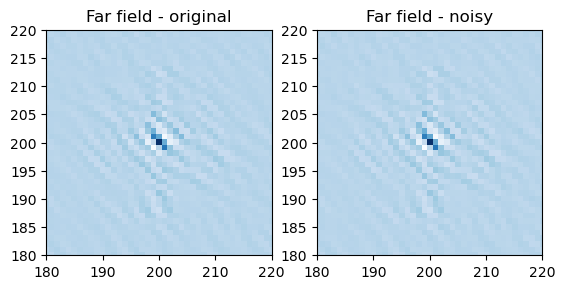

In [8]:
# Step 1: Calculate the signal power (mean squared intensity of the original image)
signal_power = np.mean(np.abs(far_field)) ** 2

#Add the noise with desired SNR (in db)
SNR = 50
noise_power = signal_power / 10**(SNR/10) 

#Add the noise
gaussian_noise = np.sqrt(noise_power) * np.random.randn(*np.shape(far_field)) #+ 1j * np.random.randn(np.shape(far_field)[0], np.shape(far_field)[1])
noisy_far_field = far_field.copy() + gaussian_noise

fig,ax = plt.subplots(1,2)
ax0 = ax[0].imshow(np.fft.fftshift(far_field), cmap = 'Blues')
s = 20
x0 = np.shape(far_field)[1]/2 - 20 ; x1 = np.shape(far_field)[1]/2 + 20
y0 = np.shape(far_field)[0]/2 - 20 ; y1 = np.shape(far_field)[0]/2 + 20
ax1 = ax[1].imshow((np.fft.fftshift(noisy_far_field)), cmap = 'Blues')
ax[0].set_xlim([x0,x1])
ax[0].set_ylim([y0,y1])
ax[1].set_xlim([x0,x1])
ax[1].set_ylim([y0,y1])
ax[0].set_title('Far field - original')
ax[1].set_title('Far field - noisy')

#### Reconstruct
And calculate the error.
We expect that the reconstructed SNR will be similar to the added noise. Since we have the ground truth, we can calculate that and check.

Adam (loss=0.589002958494755, grad=None): 100%|████████████████████████████████████████| 10/10 [00:01<00:00,  7.50it/s]


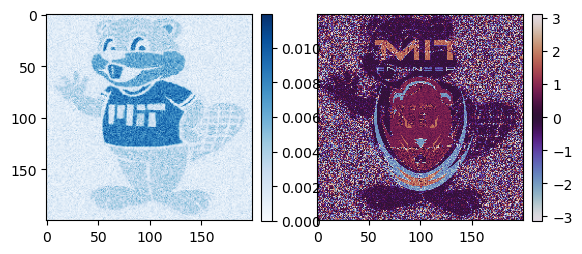

Reconstruction Relative Squared Error is 1.58e-03
Reconstruction SNR is 56.0 dB, the original SNR was 50.0 dB


In [9]:
reconstruction = phastphase.retrieve(
    noisy_far_field,
    wanted_size,             #known support
    reference_point=[0,0],    #known reference bright spot
    verbose = True,
    adam_iters = 10,
    grad_tolerance = 1e-12
)

#Plot
plot_mag_phase(reconstruction,bright_spot = [0,0])

#Calcualte the error
err = np.linalg.norm(reconstruction - near_field) / np.linalg.norm(near_field)
print(f'Reconstruction Relative Squared Error is {err:.2e}')

#We can also check if the SNR of the resconstruction is similar to the input SNR:
signal_power  = np.mean(np.abs(near_field) ** 2)
noise_power = np.mean(np.abs(near_field - reconstruction) ** 2)
snr = 10 * np.log10(signal_power / noise_power)
print(f'Reconstruction SNR is {snr:.1f} dB, the original SNR was {SNR:.1f} dB')